In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])} #--upgrade --force-reinstall
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 274 kB 5.0 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=8afea74708111db590933ad586fd7297404b03eb0d2c3b2b0fa45416d3fd8d4e
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.2.0 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
Cloning into 'detectron2'...
remote: Enumerating objects: 14608, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 

In [4]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
torch:  1.12 ; cuda:  cu113


In [10]:
%cd /content/

/content


In [5]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

#Load the data

In [10]:
!git clone https://github.com/akarazniewicz/cocosplit.git
%cd cocosplit
!pip install -r requirements.txt -q
!python cocosplit.py --having-annotations --multi-class -s 0.8 /content/drive/MyDrive/Colab_Notebooks/DKNSB_assigment_yolo/coco-annotated/instances_default.json /content/drive/MyDrive/Colab_Notebooks/DKNSB_assigment_yolo/coco-annotated/train.json /content/drive/MyDrive/Colab_Notebooks/DKNSB_assigment_yolo/coco-annotated/test.json

Cloning into 'cocosplit'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 39 (delta 9), reused 9 (delta 4), pack-reused 11
Unpacking objects: 100% (39/39), done.
/content/cocosplit/cocosplit
     |████████████████████████████████| 89 kB 4.3 MB/s 
Saved 28 entries in /content/drive/MyDrive/Colab_Notebooks/DKNSB_assigment_yolo/coco-annotated/train.json and 7 in /content/drive/MyDrive/Colab_Notebooks/DKNSB_assigment_yolo/coco-annotated/test.json


In [12]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train2", {}, "/content/drive/MyDrive/Colab_Notebooks/DKNSB_assigment_yolo/coco-annotated/train.json", "/content/drive/MyDrive/Colab_Notebooks/DKNSB_assigment_yolo/coco-annotated/images")
register_coco_instances("my_dataset_val2", {}, "/content/drive/MyDrive/Colab_Notebooks/DKNSB_assigment_yolo/coco-annotated/test.json", "/content/drive/MyDrive/Colab_Notebooks/DKNSB_assigment_yolo/coco-annotated/images")

In [14]:
class MyTrainer(DefaultTrainer):

    @classmethod
    def build_train_loader(cls, cfg):
        mapper = DatasetMapper(cfg, is_train=True, augmentations=[T.Resize((800, 800))])
        return build_detection_train_loader(cfg, mapper=mapper)

In [15]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train2",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 9  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[11/17 15:59:59 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:05, 29.9MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[11/17 16:00:05 d2.engine.train_loop]: Starting training from iteration 0
[11/17 16:00:18 d2.utils.events]:  eta: 0:02:37  iter: 19  total_loss: 2.939  loss_cls: 2.004  loss_box_reg: 0.7963  loss_rpn_cls: 0.1261  loss_rpn_loc: 0.01761  time: 0.5920  data_time: 0.1348  lr: 1.6068e-05  max_mem: 3816M
[11/17 16:00:28 d2.utils.events]:  eta: 0:02:17  iter: 39  total_loss: 2.494  loss_cls: 1.635  loss_box_reg: 0.8374  loss_rpn_cls: 0.06073  loss_rpn_loc: 0.01101  time: 0.5512  data_time: 0.0564  lr: 3.2718e-05  max_mem: 3816M
[11/17 16:00:38 d2.utils.events]:  eta: 0:02:03  iter: 59  total_loss: 2.012  loss_cls: 1.059  loss_box_reg: 0.9025  loss_rpn_cls: 0.0172  loss_rpn_loc: 0.0137  time: 0.5290  data_time: 0.0587  lr: 4.9367e-05  max_mem: 3816M
[11/17 16:00:48 d2.utils.events]:  eta: 0:01:50  iter: 79  total_loss: 1.747  loss_cls: 0.86  loss_box_reg: 0.8871  loss_rpn_cls: 0.00277  loss_rpn_loc: 0.009205  time: 0.5198  data_time: 0.0438  lr: 6.6017e-05  max_mem: 3816M
[11/17 16:00:58 d2.ut

In [17]:
os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

'./output/model_final.pth'

In [18]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[11/17 16:06:13 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

In [20]:
dataset_metadata = MetadataCatalog.get("my_dataset_train2")

In [26]:
dataset_metadata

Metadata(evaluator_type='coco', image_root='/content/drive/MyDrive/Colab_Notebooks/DKNSB_assigment_yolo/coco-annotated/images', json_file='/content/drive/MyDrive/Colab_Notebooks/DKNSB_assigment_yolo/coco-annotated/train.json', name='my_dataset_train2', thing_classes=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i'], thing_dataset_id_to_contiguous_id={1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8})

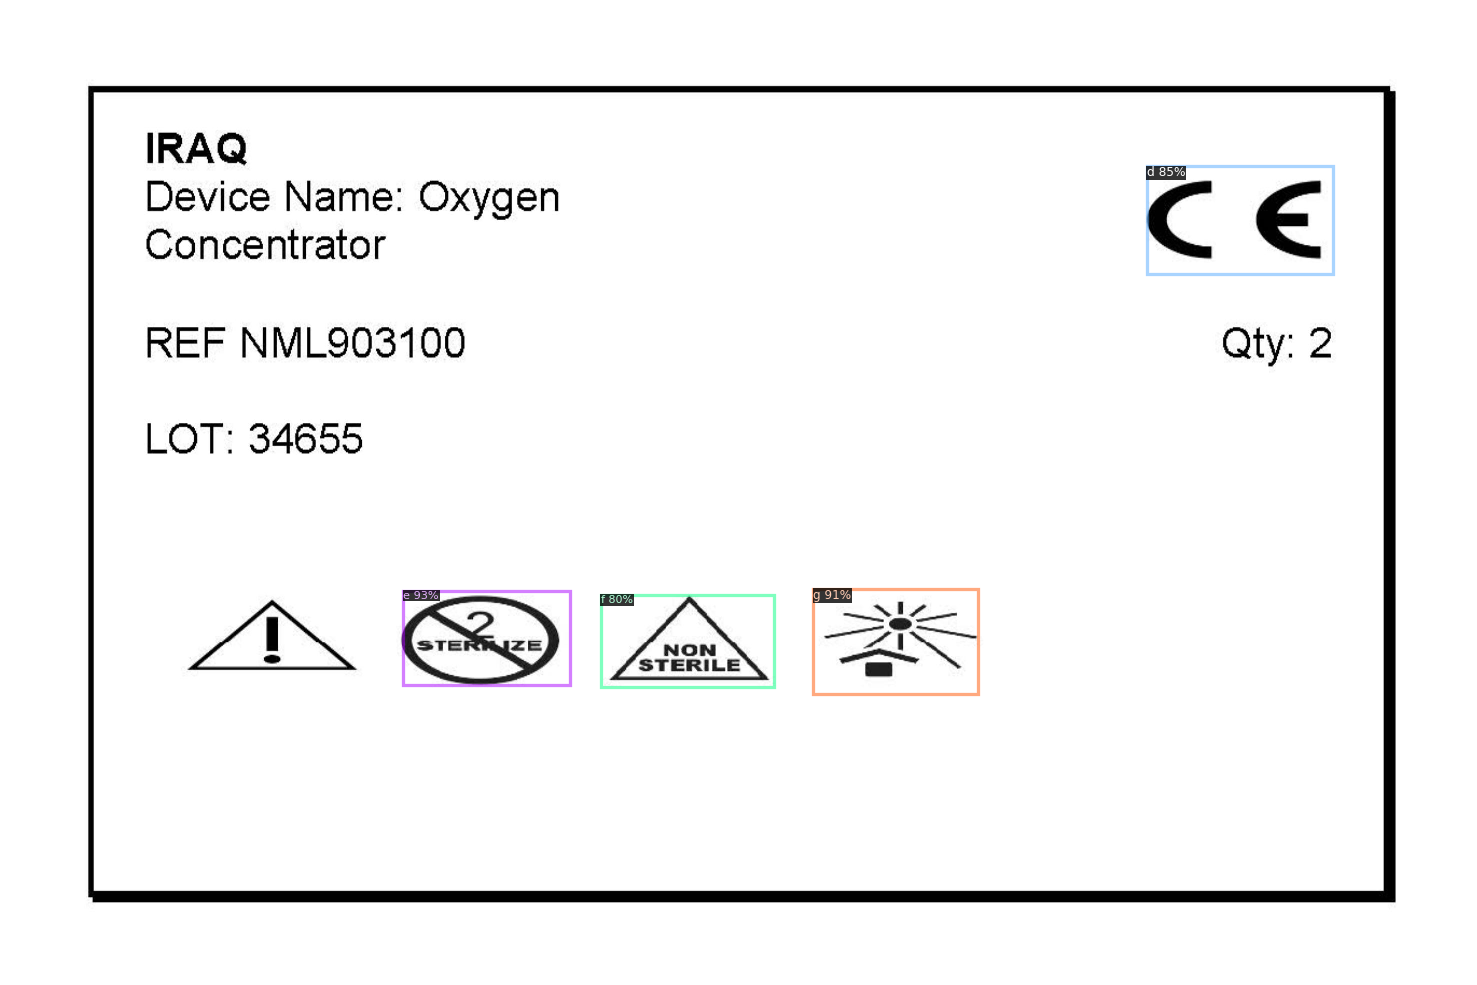

In [22]:
from google.colab.patches import cv2_imshow
from detectron2.utils.visualizer import ColorMode

im = cv2.imread("/content/drive/MyDrive/Colab_Notebooks/DKNSB_assigment_yolo/coco-annotated/images/img_7.jpeg")
outputs = predictor(
    im)
v = Visualizer(im[:, :, ::-1],
                metadata=dataset_metadata,
                scale=0.5,
                instance_mode=ColorMode.IMAGE_BW
                )
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
img = cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_RGBA2RGB)
# plt.imsave(os.path.join(os.path.join(cfg.OUTPUT_DIR, 'visualization'), str(d["image_id"]) + '.png'), img)
cv2_imshow(img)

In [25]:
!cp /content/cocosplit/cocosplit/output/* /content/drive/MyDrive/Colab_Notebooks/DKNSB_assigment_yolo/MODELS_TRAINED/

#Inference

In [ ]:
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer, ColorMode
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import cv2
import os

#How to save metadata of a dataset for external use?
'''https://github.com/facebookresearch/detectron2/issues/1969'''

cfg.MODEL.WEIGHTS = os.path.join("model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8
predictor = DefaultPredictor(cfg)
im = cv2.imread("/content/drive/MyDrive/Colab_Notebooks/DKNSB_assigment_yolo/coco-annotated/images/img_7.jpeg")
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
                metadata=dataset_metadata,
                scale=0.5,
                instance_mode=ColorMode.IMAGE_BW
                )
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
img = cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_RGBA2RGB)
# plt.imsave(os.path.join(os.path.join(cfg.OUTPUT_DIR, 'visualization'), str(d["image_id"]) + '.png'), img)
cv2_imshow(img)